In [7]:
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
from nltk.corpus import stopwords

import os #For looking through files
import os.path #For managing file paths
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [8]:
news_df1 = pd.read_pickle('../news_df_norm1.pkl')

In [9]:
news_df2 = pd.read_pickle('../news_df_norm2.pkl')

In [10]:
news_df = pd.concat([news_df1, news_df2])

In [11]:
our_stops = lucem_illud.stop_words_basic

def prepare_dataframe(dataframe, text_column):
    dataframe['tokenized_sents'] = dataframe[text_column].apply(
        lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
    dataframe['normalized_sents'] = dataframe['tokenized_sents'].apply(
        lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = our_stops, stemmer = None) for s in x])

def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [12]:
#prepare df
prepare_dataframe(news_df, 'text')
news_w2v = gensim.models.word2vec.Word2Vec(news_df['normalized_sents'].sum())

In [13]:
#words to create dimensions
news_target_words = ['arab', 'china', 'india', 'america', 'uk', 'australia', 'nigeria', 'kenya']
news_target_words += ['rich', 'developed', 'wealth', 'developing', 'poor', 'low', 'solution', 'hope', 'action','risk', 'fear', 'disaster']
news_target_words += ['research', 'report', 'science', 'hoax', 'alternative', 'plot', 'agreement', 'government', 'international', 'resource','energy','carbon']

In [18]:
def wordDimension(news_w2v, news_target_words):
    wordsSubMatrix = []
    for word in news_target_words:
        wordsSubMatrix.append(news_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)

    news_pca_words = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    news_reduced_pca = news_pca_words.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    news_tsne_words = sklearn.manifold.TSNE(n_components = 2).fit_transform(news_reduced_pca)

    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(news_tsne_words[:, 0], news_tsne_words[:, 1], alpha = 0) #Making the points invisible
    for i, word in enumerate(news_target_words):
        ax.annotate(word, (news_tsne_words[:, 0][i],news_tsne_words[:, 1][i]), size =  20 * (len(news_target_words) - i) / len(news_target_words))
    plt.xticks(())
    plt.yticks(())
    plt.show()

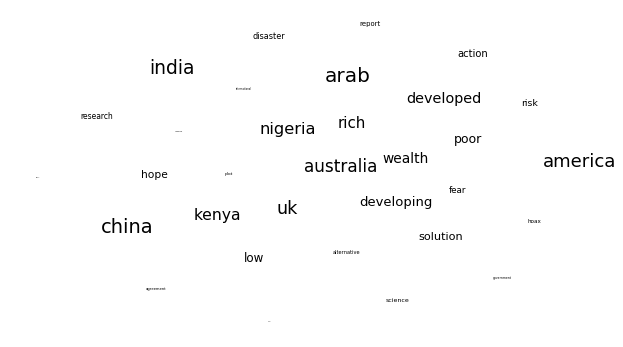

In [19]:
wordDimension(news_w2v, news_target_words)

In [15]:
def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def makeDF2(model, word_list):
    g = []
    r = []
    c = []
    e = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_class.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_attitude.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_truth.reshape(1,-1))[0][0])
        e.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_ecopoli.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'wealth': g, 'attitude': r, 'truth': c, 'political-economy': e}, index = word_list)
    return df



NameError: name 'dimension' is not defined

In [ ]:
dim_class = dimension(news_w2v, ['rich', 'developed', 'wealth'], ['developing', 'poor', 'low'])
dim_attitude = dimension(news_w2v, ['solution', 'hope', 'action'],['risk', 'fear', 'disaster'])
dim_truth = dimension(news_w2v, ['research', 'report', 'science'], ['hoax', 'alternative', 'plot'])
dim_ecopoli = dimension(news_w2v, ['agreement', 'government', 'international'], ['resource','energy','carbon'])
dim_countries = ['kenya', 'saudi', 'china', 'india', 'america', 'uk', 'australia', 'nigeria']

country_df = makeDF2(news_w2v, dim_countries)

fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(141)
PlotDimension(ax1, country_df, 'wealth')
ax2 = fig.add_subplot(142)
PlotDimension(ax2, country_df, 'attitude')
ax3 = fig.add_subplot(143)
PlotDimension(ax3, country_df, 'truth')
ax4 = fig.add_subplot(144)
PlotDimension(ax4, country_df, 'political-economy')
plt.show()